# Model
Pipeline that defines the model used to training and test the model specified.

# Download the dataset zip file
This section focus on the download do dataset to local machine.

Cleaning temporary directories

In [180]:
%rm -rf './sample_data' 'dataset' 'execution-logs' 'checkpoint' 'history.json'

Importing dependencies

In [181]:
from google.colab import drive
from zipfile import ZipFile
from glob import glob
from uuid import uuid4
from tqdm import tqdm
from psutil import cpu_count, cpu_stats, virtual_memory
from tensorflow.keras import backend
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications import InceptionResNetV2, VGG16, VGG19, ResNet152, InceptionV3
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import numpy as np
import shutil
import json
import os
import re

Defining the global constants

In [182]:
class Constants(object):
  LOG_ENABLED = True
  LEARNING_RATE_DECAY = True
  LOG_PATH = './execution-logs'
  DRIVE_MOUNT_PATH = './gdrive'
  DRIVE_PATH = f'{DRIVE_MOUNT_PATH}/My Drive/Colab Notebooks'
  ZIP_DATASET_DRIVE_PATH = f'{DRIVE_PATH}/augmented-dataset.zip'
  DRIVE_CHECKPOINTS_PATH = f'{DRIVE_PATH}/checkpoints'
  DATASET_PATH = './dataset'
  TRAINING_DATASET_PATH = f'{DATASET_PATH}/train'
  VALIDATION_DATASET_PATH = f'{DATASET_PATH}/val'
  TEST_DATASET_PATH = f'{DATASET_PATH}/test'
  BATCH_SIZE = 16
  IMAGE_HEIGHT = 224
  IMAGE_WIDTH = 224
  CHANNEL_SIZE = 3
  IMAGE_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, CHANNEL_SIZE)
  SEED = 133

Log hardware specifications in `execution-logs` folder

In [183]:
def __log_hardware_info():
  from psutil import cpu_count, cpu_stats, virtual_memory
  import os

  # Create hardware-info directory
  if not os.path.exists(Constants.LOG_PATH):
    os.mkdir(Constants.LOG_PATH)

  # Log cpu informations
  %cat /proc/cpuinfo > './execution-logs/cpu.log'

  # Log general informations
  general_info = {
      'cpu_count': cpu_count(),
      'cpu_stats': cpu_stats(),
      'virtual_memory': virtual_memory()
  }
  with open(f'{Constants.LOG_PATH}/general.log', 'w') as file:
    file.write(str(general_info))

if Constants.LOG_ENABLED:
  __log_hardware_info()

Mounting Google Drive in this machine and copy the dataset folder from Google Drive mounted to current path

In [184]:
drive.mount(Constants.DRIVE_MOUNT_PATH, force_remount=True, timeout_ms=60000)

Mounted at ./gdrive


Copying from Google Drive the dataset to current path

In [185]:
zip_ref = ZipFile(Constants.ZIP_DATASET_DRIVE_PATH, 'r')
zip_ref.extractall(Constants.DATASET_PATH)
zip_ref.close()

# Create the model

Section dedicated to create the CNN model.

Define the training and validation dataset divisions.

In [186]:
def normalize_data(dataset):
  # Notice the pixel values are now in [min 0, max 1]
  normalization_layer = tf.keras.layers.Rescaling(1./255)
  return dataset.map(lambda x, y: (normalization_layer(x), y))

def get_training_dataset():
  return tf.keras.utils.image_dataset_from_directory(
      # Constants.DATASET_PATH,
      Constants.TRAINING_DATASET_PATH,
      # labels='inferred',
      label_mode='categorical',
      # validation_split=0.2,
      color_mode='rgb',
      shuffle=True,
      # subset="training",
      seed=Constants.SEED,
      image_size=(Constants.IMAGE_HEIGHT, Constants.IMAGE_WIDTH),
      batch_size=Constants.BATCH_SIZE
  )

def get_validation_dataset():
  return tf.keras.utils.image_dataset_from_directory(
      # Constants.DATASET_PATH,
      Constants.VALIDATION_DATASET_PATH,
      # labels='inferred',
      label_mode='categorical',
      # validation_split=0.2,
      color_mode='rgb',
      shuffle=True,
      # subset="validation",
      seed=Constants.SEED,
      image_size=(Constants.IMAGE_HEIGHT, Constants.IMAGE_WIDTH),
      batch_size=Constants.BATCH_SIZE
  )

def get_test_dataset():
  return tf.keras.utils.image_dataset_from_directory(
      # Constants.DATASET_PATH,
      Constants.TEST_DATASET_PATH,
      # labels='inferred',
      label_mode='categorical',
      # validation_split=0.2,
      color_mode='rgb',
      shuffle=True,
      # subset="validation",
      seed=Constants.SEED,
      image_size=(Constants.IMAGE_HEIGHT, Constants.IMAGE_WIDTH),
      # batch_size=Constants.BATCH_SIZE
  )

# Training dataset
training_dataset = get_training_dataset()
training_dataset_normalized = normalize_data(training_dataset)

# Validation dataset
validation_dataset = get_validation_dataset()

# Test dataset
test_dataset = get_test_dataset()

# Number of classes
number_class = len(training_dataset.class_names)

Found 4123 files belonging to 48 classes.
Found 169 files belonging to 48 classes.
Found 191 files belonging to 48 classes.


[Tune datasets](https://www.tensorflow.org/guide/data_performance) applying caching

In [187]:
AUTOTUNE = tf.data.AUTOTUNE
training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Define the model architecture

In [188]:
"""
INCEPTION RESNET V2
"""
def inception_resnet_v2_model():
  model = InceptionResNetV2(input_shape=Constants.IMAGE_SHAPE, 
                            weights=None, 
                            classes=number_class)
  model.summary()
  return model

def inception_resnet_v2_pretrained_model():
  model = InceptionResNetV2(input_shape=Constants.IMAGE_SHAPE, 
                            include_top=False, 
                            weights='imagenet', 
                            classes=number_class)
  
  x = GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = Dense(number_class, activation='softmax', name='predictions')(x)

  model = Model(model.input, x)
  model.summary()
  return model

"""
RESTNET-152
"""
def vgg_16_model():
  model = VGG16(input_shape=Constants.IMAGE_SHAPE, 
                weights=None, 
                classes=number_class)
  model.summary()
  return model

def vgg_16_pretrained_model():
  model = VGG16(input_shape=Constants.IMAGE_SHAPE, 
                include_top=False, 
                weights='imagenet', 
                classes=number_class)
  
  x = GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = Dense(number_class, activation='softmax', name='predictions')(x)

  model = Model(model.input, x)
  model.summary()
  return model

"""
VGG19
"""
def vgg_19_model():
  model = VGG19(input_shape=Constants.IMAGE_SHAPE, 
                weights=None, 
                classes=number_class)
  
  model.summary()
  return model

def vgg_19_pretrained_model():
  model = VGG19(input_shape=Constants.IMAGE_SHAPE, 
                include_top=False, 
                weights='imagenet', 
                classes=number_class)
  
  x = GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = Dense(number_class, activation='softmax', name='predictions')(x)

  model = Model(model.input, x)
  model.summary()
  return model

"""
VGG16 
"""
def resnet_152_model():
  model = ResNet152(input_shape=Constants.IMAGE_SHAPE, 
                    weights=None, 
                    classes=number_class)
  model.summary()
  return model

def resnet_152_pretrained_model():
  model = ResNet152(input_shape=Constants.IMAGE_SHAPE, 
                    include_top=False, 
                    weights='imagenet', 
                    classes=number_class)
  
  x = GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = Dense(number_class, activation='softmax', name='predictions')(x)

  model = Model(model.input, x)
  model.summary()
  return model

"""
INCEPTION V3 
"""
def inception_v3_model():
  model = InceptionV3(input_shape=Constants.IMAGE_SHAPE, 
                      weights=None, 
                      classes=number_class)
  model.summary()
  return model

def inception_v3_pretrained_model():
  model = InceptionV3(input_shape=Constants.IMAGE_SHAPE, 
                      include_top=False, 
                      weights='imagenet', 
                      classes=number_class)
  
  x = GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = Dense(number_class, activation='softmax', name='predictions')(x)

  model = Model(model.input, x)
  model.summary()
  return model

Define training callbacks

In [189]:
class TimestampCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    import datetime
    self.__epoch_start = datetime.datetime.utcnow()

  def on_epoch_end(self, epoch, logs=None):
    import datetime
    timedelta_sec = datetime.datetime.utcnow() - self.__epoch_start
    logs["duration"] = timedelta_sec.total_seconds()

def learning_rate_decay_scheduler(epoch):
  learning_rate = 0.003
  if Constants.LEARNING_RATE_DECAY:
    if epoch > 40:
      learning_rate = 0.0005
    if epoch > 50:
      learning_rate = 0.0001
  return learning_rate

# Define callbacks
callbacks = [LearningRateScheduler(learning_rate_decay_scheduler), TimestampCallback()]

Configure constants for model

In [190]:
class ModelConstants(object):
  """
  Currently models available
  01. inception_resnet_v2_model
  02. inception_resnet_v2_pretrained_model
  03. vgg_16_model
  04. vgg_16_pretrained_model
  05. vgg_19_model
  06. vgg_19_pretrained_model
  07. resnet_152_model
  08. resnet_152_pretrained_model
  09. inception_v3_model
  10. inception_v3_pretrained_model
  """
  MODEL_NAME = 'inception_v3_pretrained_model'
  EPOCHS = 3

  """
  Checkpoint desired to be loaded
  01. <directory_name_required_on_google_cloud>
  02. disable
  """
  CHECKPOINT_NAME = 'inception_v3_pretrained_model_60epochs_95.86acc_25min'
  DRIVE_CHECKPOINT_PATH = f'{Constants.DRIVE_CHECKPOINTS_PATH}/{CHECKPOINT_NAME}'

Train the model

In [191]:
def get_model():
  model = globals()[ModelConstants.MODEL_NAME]()
  model.compile(loss='categorical_crossentropy',
                optimizer=tf.optimizers.SGD(learning_rate=0.003, momentum=0.9, nesterov=False),
                metrics=['accuracy', 
                         'top_k_categorical_accuracy', 
                         tf.keras.metrics.Precision(name='precision'), 
                         tf.keras.metrics.Recall(name='recall'),
                         tf.keras.metrics.TruePositives(name='true_positives'),
                         tf.keras.metrics.TrueNegatives(name='true_negatives'),
                         tf.keras.metrics.FalsePositives(name='false_positives'),
                         tf.keras.metrics.FalseNegatives(name='false_negatives'),
                         tf.keras.metrics.AUC(name='auc')])
  return model
    
def is_model_saved_in_cloud():
  return os.path.exists(ModelConstants.DRIVE_CHECKPOINT_PATH)

def load_checkpoint_saved():
  if is_model_saved_in_cloud():
    history = json.load(open(f'{ModelConstants.DRIVE_CHECKPOINT_PATH}/history.json', 'r'))
    model = load_model(f'{ModelConstants.DRIVE_CHECKPOINT_PATH}/model')
  return model, history

def fit(model):
  return model.fit( 
      training_dataset,
      validation_data=validation_dataset,
      epochs=ModelConstants.EPOCHS,
      callbacks=callbacks
  )

def train_model():
  if is_model_saved_in_cloud():
    model, history = load_checkpoint_saved()
    return model, history
  else:
    model = get_model()
    history = fit(model)
    return model, history

model, history = train_model()

Extract data from history object

In [192]:
def get_data_from_history():
  if hasattr(history, 'history'):
    return history.history
  return history

history = get_data_from_history()

Define checkpoint constants

In [193]:
def get_checkpoint_name():
  validation_accuracy = '{:.2f}'.format(round(history['val_accuracy'][-1]*100, 2))
  duration = '{:.0f}'.format(round(sum(history["duration"])/60, 2))
  return f'{ModelConstants.MODEL_NAME}_{ModelConstants.EPOCHS}epochs_{validation_accuracy}acc_{duration}min'

class CheckpointConstants(object):
  CHECKPOINT_NAME = get_checkpoint_name()
  DRIVE_CHECKPOINT_PATH = f'{Constants.DRIVE_CHECKPOINTS_PATH}/{CHECKPOINT_NAME}'
  DRIVE_CHECKPOINT_MODEL_PATH = f'{DRIVE_CHECKPOINT_PATH}/model'
  DRIVE_CHECKPOINT_HISTORY_FILE_PATH = f'{DRIVE_CHECKPOINT_PATH}/history.json'
  LOCAL_CHECKPOINT_PATH = './checkpoint'
  LOCAL_HISTORY_FILE_PATH = './history.json'

Save the model in Google Drive if not exists

In [194]:
def save_model_in_root(model):
  if os.path.exists(CheckpointConstants.LOCAL_CHECKPOINT_PATH):
    shutil.rmtree(CheckpointConstants.LOCAL_CHECKPOINT_PATH)
  model.save(CheckpointConstants.LOCAL_CHECKPOINT_PATH, save_format='tf')

def copy_model_in_cloud():
  if os.path.exists(CheckpointConstants.DRIVE_CHECKPOINT_MODEL_PATH):
    shutil.rmtree(CheckpointConstants.DRIVE_CHECKPOINT_MODEL_PATH)
  shutil.copytree(CheckpointConstants.LOCAL_CHECKPOINT_PATH, CheckpointConstants.DRIVE_CHECKPOINT_MODEL_PATH)

def save_model(model):
  save_model_in_root(model)
  copy_model_in_cloud()

def save_history_in_root(history):
  history_logs = history
  learning_rates = history_logs['lr']
  history_logs['lr'] = list(map(lambda x: float("{:.8f}".format(float(x))), learning_rates))
  json.dump(history_logs, open(CheckpointConstants.LOCAL_HISTORY_FILE_PATH, 'w'))

def copy_history_in_cloud():
  if os.path.exists(CheckpointConstants.DRIVE_CHECKPOINT_HISTORY_FILE_PATH):
    os.unlink(CheckpointConstants.DRIVE_CHECKPOINT_HISTORY_FILE_PATH)
  shutil.copy(CheckpointConstants.LOCAL_HISTORY_FILE_PATH, CheckpointConstants.DRIVE_CHECKPOINT_HISTORY_FILE_PATH)

def save_history(history):
  save_history_in_root(history)
  copy_history_in_cloud()

if not os.path.exists(CheckpointConstants.DRIVE_CHECKPOINT_PATH):
  save_model(model)
  save_history(history)

INFO:tensorflow:Assets written to: ./checkpoint/assets


Compile tensorflow log and show it

In [195]:
print('\n- TRAINING METRICS')
print(f'loss - last: {history["loss"][-1]}, max: {max(history["loss"])}, min {min(history["loss"])}')
print(f'accuracy - last: {history["accuracy"][-1]}, max: {max(history["accuracy"])}, min {min(history["accuracy"])}')

print('\n- VALIDATION METRICS')
print(f'val_loss - last: {history["val_loss"][-1]}, max: {max(history["val_loss"])}, min {min(history["val_loss"])}')
print(f'val_accuracy - last: {history["val_accuracy"][-1]}, max: {max(history["val_accuracy"])}, min {min(history["val_accuracy"])}')

print('\n- DURATION')
print(f'duration - last: {history["duration"][-1]}, max: {max(history["duration"])}, min {min(history["duration"])}')
print(f'duration - hours: {sum(history["duration"])/3600}, minutes: {sum(history["duration"])/60}, seconds: {sum(history["duration"])}')


- TRAINING METRICS
loss - last: 0.0002677011943887919, max: 1.1136705875396729, min 0.0002677011943887919
accuracy - last: 1.0, max: 1.0, min 0.6960950493812561

- VALIDATION METRICS
val_loss - last: 0.14687545597553253, max: 0.45890650153160095, min 0.11981130391359329
val_accuracy - last: 0.9585798978805542, max: 0.9704142212867737, min 0.8520709872245789

- DURATION
duration - last: 24.587306, max: 60.739032, min 24.57266
duration - hours: 0.42230822388888883, minutes: 25.33849343333333, seconds: 1520.3096059999998


# Metrics
Section to expose all metrics collected from model execution

Model accuracy chart

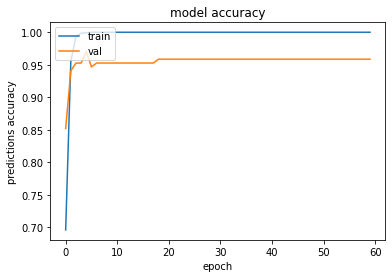

In [196]:
def accuracy_chart():
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('predictions accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

accuracy_chart()

Model loss chart

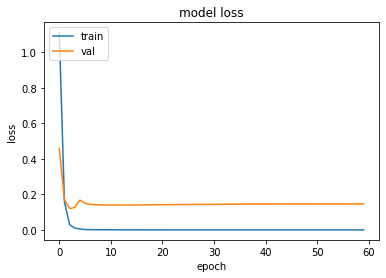

In [197]:
def loss_chart():
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

loss_chart()

Evaluate the results

In [198]:
results = model.evaluate(test_dataset, batch_size=Constants.BATCH_SIZE)
print("Test loss, test accuracy:", results)

6/6 [==============================] - 3s 89ms/step - loss: 0.2666 - accuracy: 0.9476 - top_k_categorical_accuracy: 1.0000
Test loss, test accuracy: [0.2666175067424774, 0.9476439952850342, 1.0]


Predict using test set

In [199]:
TEST_SET_SIZE = len(glob(f'{Constants.TEST_DATASET_PATH}/**/*.jpg')) + len(glob(f'{Constants.TEST_DATASET_PATH}/**/*.JPG'))

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.unbatch().batch(N)
  for images, labels in dataset:
      numpy_images = images.numpy()
      numpy_labels = labels.numpy()
      break;  
  return numpy_images, numpy_labels

images, labels = dataset_to_numpy_util(test_dataset, TEST_SET_SIZE)

# Predict
predictions = model.predict(images)

Show prediction result

In [200]:
CLASSES = test_dataset.class_names

def get_class_name_from_label_and_target(prediction_label, expected_label):
  one_hot_label = np.argmax(prediction_label, axis=-1)
  one_hot_expected_label = np.argmax(expected_label, axis=-1)
  correct = (one_hot_label == one_hot_expected_label)
  return CLASSES[one_hot_label], correct, (CLASSES[one_hot_expected_label] if not correct else '-')

def get_processed_predictions(images, predictions, labels):
  results = list()
  score = list()
  for i, image in enumerate(images):
    class_name, correct, should_be = get_class_name_from_label_and_target(predictions[i], labels[i])
    results.append([class_name, bool(correct), should_be])
    score.append(bool(correct))
  return results

def show_predictions():
  from tabulate import tabulate
  results = get_processed_predictions(images, predictions, labels)
  results.sort()
  print(tabulate(results, headers=['Class name', 'Correct?', 'Shoud be?']))

show_predictions()

Class name                    Correct?    Shoud be?
----------------------------  ----------  ------------------------
apis_cerana                   True        -
apis_cerana                   True        -
apis_cerana                   True        -
apis_cerana                   True        -
apis_dorsata                  True        -
apis_dorsata                  True        -
apis_dorsata                  True        -
apis_dorsata                  True        -
apis_mellifera                True        -
apis_mellifera                True        -
apis_mellifera                True        -
apis_mellifera                True        -
apis_mellifera                True        -
apisflorea                    True        -
apisflorea                    True        -
apisflorea                    True        -
apisflorea                    True        -
austroplebeia_australis       False       austroplebeia_striped
austroplebeia_australis       False       austroplebeia_striped
austr

Print in Table (excel) format

In [201]:
def show_results_in_table_format():
  results = get_processed_predictions(images, predictions, labels)
  table = [','.join(map(str, line)) for line in results]
  print(*table, sep='\n')

show_results_in_table_format()

mourella_caerulea,True,-
plebeia_flavocincta,True,-
tripoxylon_lactitarse,True,-
meliponula_bocandei,True,-
austroplebeia_symei,True,-
apis_cerana,True,-
melipona_bicolor,True,-
plebeia_droryana,True,-
melipona_flavolineata,True,-
melipona_scutelaris,True,-
geotrigona_sp,True,-
partamona_helleri,True,-
bombus_brasiliensis,True,-
bombus_pauloensis,True,-
lestrimellita_limao,True,-
apisflorea,True,-
melipona_scutelaris,True,-
scaura_latitarsis,True,-
plebeia_remota,True,-
nannotrigona_testaceicornis,True,-
lestrimellita_limao,True,-
nannotrigona_testaceicornis,True,-
austroplebeia_australis,True,-
meliponula_bocandei,True,-
mourella_caerulea,True,-
melipona_plebeia_nigriceps,True,-
melipona_paratrigona_subnuda,True,-
austroplebeia_essinatoni,True,-
austroplebeia_australis,True,-
mel_plebeia_sp,True,-
tripoxylon_aurifrons,True,-
melipona_plebeia_nigriceps,True,-
austroplebeia_australis,True,-
axestotrigona_ferruginea,True,-
scaptotrigona_bipunctata,True,-
melipona_mandacaia,True,-
melipon

Calculate hits

In [202]:
success = round(results[1] * TEST_SET_SIZE)
fail = TEST_SET_SIZE - success
print(f'Succeeded in {success} images and failed {fail} images')

Succeeded in 181 images and failed 10 images


Plot model

In [203]:
# tf.keras.utils.plot_model(
#     model,
#     to_file='model.png',
#     show_shapes=False,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=False
# )

Plot confusion matrix

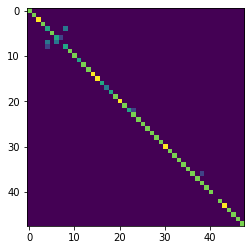

In [204]:
def plot_confusion_matrix():
  true_classes = tf.argmax(labels, 1)
  predicted_classes = tf.argmax(predictions, 1)
  confusion = tf.math.confusion_matrix(true_classes, predicted_classes, number_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=number_class)
  disp.plot()
  plt.show()

try:
  plot_confusion_matrix()
except:
  pass